In [18]:
import pandas as pd
import yfinance as yf
import numpy as np
from fredapi import Fred

In [19]:
# Define the tickers and the date range
tickers = ["AGG", "SPY", "VT"]
start_date = "2019-12-31"
end_date = "2024-08-01"

# Download the data
fund_data = yf.download(tickers, start=start_date, end=end_date)

fred = Fred(api_key='1cac913622d94138eb2b76fe5842bc38')
tbill_3month_rate_df = fred.get_series('DTB3')

# Source CSV: https://wholesale.banking.societegenerale.com/fileadmin/indices_feeds/index_website/index_website_daily.csv?q=0.801015001701092
sg_index_df = pd.read_csv("C:\\Users\mason\PycharmProjects\quantitative-finance\data_storage\sg_index\sg_trend_nav.csv").ffill()
sg_index_df.loc[:, 'trade_date'] = pd.to_datetime(sg_index_df['trade_date'])
sg_index_df = sg_index_df.rename(columns={'trade_date': 'Date'}).set_index('Date')

[*********************100%%**********************]  3 of 3 completed


In [20]:
FILTER_START_DATE = "2000-12-31"

In [21]:
adj_close_df = fund_data['Adj Close']
data_df = pd.merge(sg_index_df, adj_close_df, left_index=True, right_index=True)
if 'SG Short-Term Traders Index' in data_df.columns:
    data_df = data_df.ffill().drop(columns=['SG Short-Term Traders Index', 'SG Multi Alternative Risk Premia Index'])

In [22]:
return_df = data_df.pct_change()
return_df.loc[:, 'VT'] = return_df['VT'].fillna(return_df['SPY'])
return_df = return_df.dropna()

In [23]:
return_df['TBill 3M Rate'] = tbill_3month_rate_df
return_df['TBill 3M Rate'] = return_df['TBill 3M Rate'].ffill() / 100
return_df['Cost of Leverage'] = return_df['TBill 3M Rate'] / 252
return_df = return_df.drop(columns=['TBill 3M Rate'])

return_df['Leveraged 95/30/50'] = (0.95 * return_df['SPY'] + 0.3 * return_df['AGG'] + 0.5 * return_df['SG Trend Index']) - (0.8 * return_df['Cost of Leverage'])
return_df['Leveraged 90/60/00'] = (0.90 * return_df['SPY'] + 0.6 * return_df['AGG']) - (0.6 * return_df['Cost of Leverage'])
return_df['Leveraged 100/00/100'] = (1 * return_df['SPY'] + 1 * return_df['SG Trend Index']) - (1 * return_df['Cost of Leverage'])
return_df['Leveraged 100/50/50'] = (0.5 * return_df['VT'] + 0.5 * return_df['SPY'] + 0.5 * return_df['SG Trend Index'] + 0.5 * return_df['AGG']) - (1 * return_df['Cost of Leverage'])
return_df['60/40'] = 0.6 * return_df['SPY'] + 0.4 * return_df['AGG']


In [24]:
return_df = return_df[return_df.index >= FILTER_START_DATE]
cumulative_return_df = np.exp(np.cumsum(np.log(return_df + 1))) - 1

In [25]:
cumulative_return_df.iloc[-1, :].sort_values(ascending=False)

Leveraged 100/00/100    1.489547
Leveraged 95/30/50      1.026247
Leveraged 100/50/50     0.868001
SPY                     0.834035
Leveraged 90/60/00      0.615792
VT                      0.554126
SG Trend Index          0.500833
60/40                   0.467560
SG CTA Index            0.332910
SG Trend Indicator      0.194344
Cost of Leverage        0.110640
AGG                    -0.013331
Name: 2024-07-31 00:00:00, dtype: float64

In [26]:
names_filter = ['SPY', 'Leveraged 95/30/50', 'Leveraged 90/60/00', 'Leveraged 100/00/100', 'Leveraged 100/50/50',
                '60/40', 'AGG', 'VT', 'SG Trend Index', 'SG CTA Index']

<Axes: xlabel='Date'>

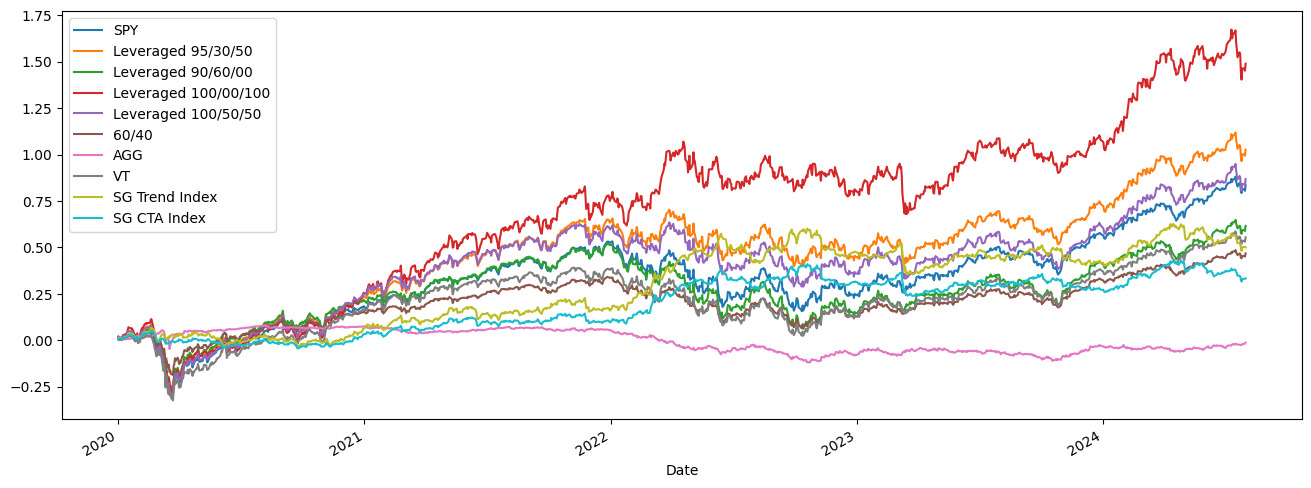

In [27]:
cumulative_return_df[names_filter].plot(figsize=(16, 6))

In [28]:
rolling_return_df = ((cumulative_return_df.shift(-252) + 1) / (cumulative_return_df + 1)) - 1

In [29]:
rolling_return_df

,SG CTA Index,SG Trend Index,SG Trend Indicator,AGG,SPY,VT,Cost of Leverage,Leveraged 95/30/50,Leveraged 90/60/00,Leveraged 100/00/100,Leveraged 100/50/50,60/40
Date,,,,,,,,,,,,
2020-01-02,0.023059,0.051555,0.081669,0.071804,0.172352,0.154192,0.003487,0.220040,0.204734,0.231428,0.232397,0.146353
2020-01-03,0.026643,0.060253,0.097721,0.067318,0.165215,0.158059,0.003432,0.216574,0.195140,0.234259,0.233301,0.140252
2020-01-06,0.035915,0.073946,0.123444,0.067083,0.168781,0.166450,0.003374,0.227917,0.198318,0.253989,0.247531,0.142250
2020-01-07,0.032044,0.071650,0.143114,0.062964,0.179085,0.178342,0.003318,0.235507,0.205089,0.262406,0.255705,0.146522
2020-01-08,0.035492,0.073059,0.140907,0.063103,0.190259,0.185464,0.003261,0.247567,0.215515,0.276131,0.266446,0.153118
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
excess_spy_df = (rolling_return_df.sub(rolling_return_df['SPY'], axis=0))

<Axes: xlabel='Date'>

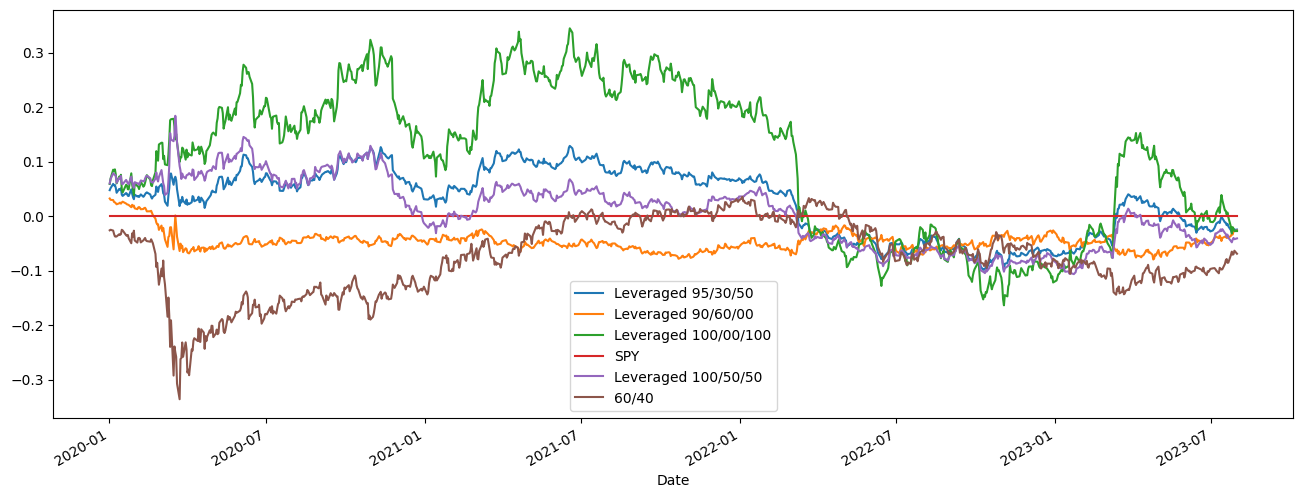

In [31]:
excess_spy_df[
    ['Leveraged 95/30/50', 'Leveraged 90/60/00', 'Leveraged 100/00/100', 'SPY', 'Leveraged 100/50/50', '60/40']].plot(figsize=(16, 6))

In [32]:
date_filter = "2010-12-31"
df = excess_spy_df.loc[excess_spy_df.index >= date_filter , :]
(df['Leveraged 95/30/50'] > 0).sum() / len(df)

0.5208333333333334

In [33]:
return_df.loc[excess_spy_df.index > date_filter, ['SG Trend Index', 'SPY', 'AGG', 'VT']].corr(method='kendall')

,SG Trend Index,SPY,AGG,VT
SG Trend Index,1.000000,0.031330,-0.235510,0.036812
SPY,0.031330,1.000000,0.097492,0.840457
AGG,-0.235510,0.097492,1.000000,0.107234
VT,0.036812,0.840457,0.107234,1.000000


In [34]:
total_days = len(cumulative_return_df.index)
trading_days_in_year = 252
annual_return_df = (cumulative_return_df.iloc[-1, :] + 1) ** (trading_days_in_year / total_days) - 1
annual_return_df.sort_values(ascending=False)

Leveraged 100/00/100    0.220819
Leveraged 95/30/50      0.167049
Leveraged 100/50/50     0.146473
SPY                     0.141880
Leveraged 90/60/00      0.110668
VT                      0.101254
SG Trend Index          0.092881
60/40                   0.087534
SG CTA Index            0.064879
SG Trend Indicator      0.039614
Cost of Leverage        0.023220
AGG                    -0.002931
Name: 2024-07-31 00:00:00, dtype: float64

In [35]:
std_df = return_df.std() * np.sqrt(trading_days_in_year)
std_df[names_filter].sort_values()

AGG                     0.069644
SG CTA Index            0.089215
SG Trend Index          0.112739
60/40                   0.137262
Leveraged 90/60/00      0.205886
VT                      0.207794
Leveraged 95/30/50      0.212593
SPY                     0.215139
Leveraged 100/50/50     0.221617
Leveraged 100/00/100    0.238431
dtype: float64

In [36]:
(annual_return_df[names_filter] / std_df).sort_values(ascending=False)

Leveraged 100/00/100    0.926134
SG Trend Index          0.823858
Leveraged 95/30/50      0.785766
SG CTA Index            0.727220
Leveraged 100/50/50     0.660928
SPY                     0.659481
60/40                   0.637714
Leveraged 90/60/00      0.537521
VT                      0.487283
AGG                    -0.042091
Cost of Leverage             NaN
SG Trend Indicator           NaN
dtype: float64

In [37]:
def calculate_max_drawdown(df):
    """
    Calculates the maximum drawdown for each column in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame where each column represents cumulative returns of assets.

    Returns:
    pd.Series: Maximum drawdowns for each column.
    """
    # Calculate the running maximum
    running_max = df.cummax()
    # Calculate drawdowns
    drawdowns = (df - running_max) / running_max
    # Calculate maximum drawdown
    max_drawdown = drawdowns.min()
    return max_drawdown

In [38]:
calculate_max_drawdown(cumulative_return_df[names_filter] + 1).sort_values(ascending=False)

SG CTA Index           -0.121272
SG Trend Index         -0.153864
AGG                    -0.184330
60/40                  -0.217170
Leveraged 90/60/00     -0.313868
Leveraged 95/30/50     -0.333913
SPY                    -0.337173
VT                     -0.342362
Leveraged 100/50/50    -0.352240
Leveraged 100/00/100   -0.355568
dtype: float64